# Exploring the Titanic Dataset (Python version)
Anton Fefilov
17 september 2016

## 1 Introduction
This is my first attempt to make ML research myself after awesome Andrew Ng's Coursera course on Machine Learning. As a basis for this work I took the awesome kernel [Exploring the Titanic Dataset](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic) authored by Megan Risdal and replicated it with Python. Also I took a lot of useful information for this work in [A Journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic) kernel by Omar El Gabry.

There are three parts to my script as follows:

*    Feature engineering
*    Missing value imputation
*    Prediction!


### 1.1 Load and check data

In [1]:
# Load packages

# pandas
import pandas as pd
from pandas import Series, DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

# configure seaborn
sns.set_style('whitegrid')

# draw graphics inline
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Now that our packages are loaded, let’s read in and take a peek at the data.

In [2]:
# get titanic & test csv files as a DataFrame
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

# preview the data structure
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# bind train and test data
titanic_df = train_df.append(test_df, ignore_index=True)

# get sense of variables and datatypes
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


We’ve got a sense of our variables, their class type, and the first few observations of each. We know we’re working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren’t 100% illuminating, here’s what we’ve got to deal with:

| Variable Name | Description |
| --- | --- |
| PassengerId | Passenger's id |
| Survived | Survived (1) or died (0) |
| Pclass | Passenger’s class |
| Name | Passenger’s name |
| Sex | Passenger’s sex |
| Age | Passenger’s age |
| SibSp | Number of siblings/spouses aboard |
| Parch | Number of parents/children aboard |
| Ticket | Ticket number |
| Fare | Fare |
| Cabin | Cabin |
| Embarked | Port of embarkation |

# 2. Feature engineering
## 2.1 What's in a name?

The first variable which catches my attention is **passenger name** because we can break it down into additional meaningful variables which can feed predictions or be used in the creation of additional new variables. For instance, **passenger title** is contained within the passenger name variable and we can use **surname** to represent families. Let’s do some **feature engineering**!

In [4]:
# Make a copy of the titanic data frame
title_df = titanic_df.copy()

# Grab title from passenger names
title_df["Name"].replace(to_replace='(.*, )|(\\..*)', value='', inplace=True, regex=True)

In [5]:
title_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,Mr,0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,Mrs,0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,Miss,0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,Mrs,0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,Mr,0,5,3,male,0,0.0,373450


In [6]:
# Show title counts by sex
title_df.groupby(["Sex", "Name"]).size().unstack(fill_value=0)

Name,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


In [7]:
# Titles with very low cell counts to be combined to "rare" level
rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
title_df.replace(rare_titles, "Rare title", inplace=True)

# Also reassign mlle, ms, and mme accordingly
title_df.replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)

In [8]:
# Show title counts by sex
title_df.groupby(["Sex", "Name"]).size().unstack(fill_value=0)

Name,Master,Miss,Mr,Mrs,Rare title
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In [9]:
# Finally, grab surname from passenger name
uniq_surname_size = titanic_df["Name"].str.split(',').str.get(0).unique().size

print("We have %(uniq_surname_size)s unique surnames. I would be interested to infer ethnicity based on surname --- another time." % locals())

We have 875 unique surnames. I would be interested to infer ethnicity based on surname --- another time.


## 2.2 Do families sink or swim together?

Now that we’ve taken care of splitting passenger name into some new variables, we can take it a step further and make some new family variables. First we’re going to make a **family size** variable based on number of siblings/spouse(s) (maybe someone has more than one spouse?) and number of children/parents.

In [10]:
# Make a copy of the titanic data frame
family_df = titanic_df.loc[:,["Parch", "SibSp", "Survived"]]

# Create a family size variable including the passenger themselves
family_df["Fsize"] = family_df.SibSp + family_df.Parch + 1

family_df.head()

,Parch,SibSp,Survived,Fsize
0,0,1,0.0,2
1,0,1,1.0,2
2,0,0,1.0,1
3,0,1,1.0,2
4,0,0,0.0,1


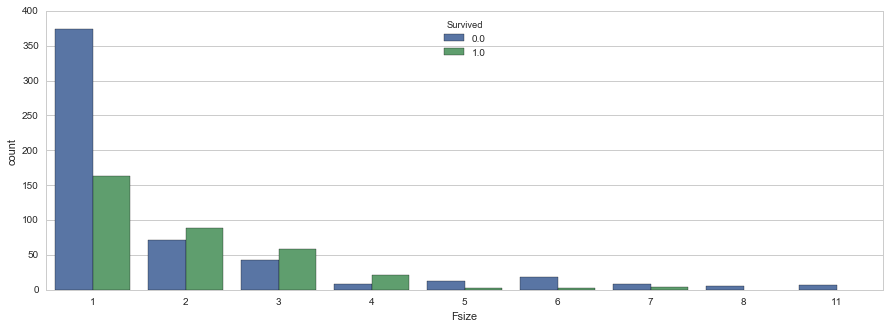

In [11]:
# make figure wider
plt.figure(figsize=(15,5))

# visualize the relationship between family size & survival
sns.countplot(x='Fsize', hue="Survived", data=family_df)

Ah hah. We can see that there’s a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let’s create a **discretized family size** variable.

In [12]:
# Discretize family size
family_df.ix[family_df.Fsize > 4, "Fsize"] = "large"
family_df.ix[family_df.Fsize == 1, "Fsize"] = 'singleton'
family_df.ix[(family_df.Fsize < 5) & (family_df.Fsize > 1), "Fsize"] = "small"


family_df.head(10)

,Parch,SibSp,Survived,Fsize
0,0,1,0.0,small
1,0,1,1.0,small
2,0,0,1.0,singleton
3,0,1,1.0,small
4,0,0,0.0,singleton
5,0,0,0.0,singleton
6,0,0,0.0,singleton
7,1,3,0.0,large
8,2,0,1.0,small
9,0,1,1.0,small


(<matplotlib.figure.Figure at 0x7f854c7556d0>,
 OrderedDict([(('small', '0.0'), (0.0, 0.0, 0.3244768921336578, 0.41983343193919809)), (('small', '1.0'), (0.0, 0.42315569107541073, 0.3244768921336578, 0.57684430892458916)), (('singleton', '0.0'), (0.3294273871831628, 0.0, 0.5967263393005967, 0.6941479982924702)), (('singleton', '1.0'), (0.3294273871831628, 0.69747025742868274, 0.5967263393005967, 0.30252974257131715)), (('large', '0.0'), (0.9311042215332644, 0.0, 0.06889577846673557, 0.83592326653091842)), (('large', '1.0'), (0.9311042215332644, 0.83924552566713095, 0.06889577846673557, 0.16075447433286888))]))

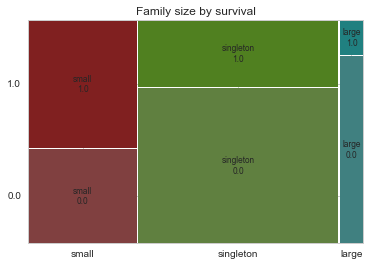

In [21]:
# Show family size by survival using a mosaic plot
mosaic(family_df, ['Fsize', 'Survived'], title="Family size by survival")

The mosaic plot shows that we preserve our rule that there’s a survival penalty among singletons and large families, but a benefit for passengers in small families. I want to do something further with our age variable, but 263 rows have missing age values, so we will have to wait until after we address missingness.